# Models of Neural Systems - Computer Practical 6
# Author: Robert Tjarko Lange

## Hodgkin-Huxley model of action potential generation

In [1]:
from __future__ import division
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# a - Base Simulation

In [2]:
class huxley_hodgkin():
    def __init__(self,
                 dt, max_T,
                 I_const=0,
                 ext_current_type="constant",
                 nu=1):
        self.E_Na = 50.0  # reversal potential sodium (mV)
        self.E_K = -77.0  # reversal potential potassium (mV)
        self.E_leak = -54.387  # reversal potential passive leakage (mV)

        self.g_Na = 120.0  # conductance sodium (nS)
        self.g_K = 36.0  # conductance potassium (nS)
        self.g_leak = 0.3  # conductance passive leakage (nS)

        # type of current applied ("constant", "temp_pulse", "sinusoidal")
        self.ext_current_type = ext_current_type 
        self.I_const = I_const
        self.nu = nu  # Sinusoidal input frequency (Hz)
        self.C_m = 1.0  # Time constant (pF)
   
        self.t = np.arange(0, max_T, dt)  # Euler Time Range

    def alpha(self, V, gate_type):
        # Define Opening Rate Equations as fct of membrane potential
        if gate_type == "n":  # K+ Activation Gate
            alpha_t = (0.01*(V + 55))/(1-np.exp(-0.1*(V + 55)))
        elif gate_type == "m":  # Na+ Activation Gate
            alpha_t = (0.1*(V + 40.0))/(1-np.exp(-0.1*(V + 40)))
        elif gate_type == "h":  # Na+ Inactivation Gate
            alpha_t = 0.07*np.exp(-0.05*(V + 65))
        return alpha_t

    def beta(self, V, gate_type):
        # Define Closing Rate Equations as fct of membrane potential
        if gate_type == "n":  # K+ Activation Gate
            beta_t = 0.125*np.exp(-0.0125*(V + 65))
        elif gate_type == "m":  # Na+ Activation Gate
            beta_t = 4*np.exp(-0.0556*(V + 65))
        elif gate_type == "h":  # Na+ Inactivation Gate
            beta_t = 1./(1 + np.exp(-0.1*(V + 35)))
        return beta_t

    def I_Na(self, m, h, V):  # Sodium current (pA)
        return self.g_Na*m**3*h*(V-self.E_Na)

    def I_K(self, n, V):  # Potassium current (pA)
        return self.g_K*n**4*(V - self.E_K)

    def I_leak(self, V):  # Leakage current (pA)
        return self.g_leak*(V - self.E_leak)

    def I_e(self, t):
        # External currents
        if self.ext_current_type == "constant":
            temp = self.I_const
        elif self.ext_current_type == "temp_pulse":
            if t <= 5:
                temp = self.I_const
            else:
                temp = 0
        elif self.ext_current_type == "sinusoidal":
            temp = self.I_const*np.sin(2*math.pi*self.nu*t)
        return temp

    def dx(self, x, gate_type):
        return self.alpha(gate_type) * (1 - x) + self.beta(gate_type) * x

    @staticmethod
    def step_all(X, t, self):
        V, m, h, n = X

        dVdt = (self.I_e(t) - self.I_Na(m, h, V) - self.I_K(n, V) - self.I_leak(V)) / self.C_m
        dmdt = self.alpha(V, "m")*(1.0 - m) - self.beta(V, "m")*m
        dhdt = self.alpha(V, "h")*(1.0 - h) - self.beta(V, "h")*h
        dndt = self.alpha(V, "n")*(1.0 - n) - self.beta(V, "n")*n
        return dVdt, dmdt, dhdt, dndt

    def run_euler(self):
        euler_out = odeint(self.step_all,
                           [-65, 0.0529, 0.5961, 0.3177],
                           self.t, args=(self,))
        V = euler_out[:,0]
        m = euler_out[:,1]
        h = euler_out[:,2]
        n = euler_out[:,3]

        I_Na_out = self.I_Na(m, h, V)
        I_K_out = self.I_K(n, V)
        I_leak_out = self.I_leak(V)
        return self.t, V, n, m, h, I_Na_out, I_K_out, I_leak_out


In [3]:
def calculate_mean_firing_rate(time, V_t, V_thresh=-54):
    # First extract spikes - very manual spike definition:
    # if previous and next potential are lower than current and
    # manually defined potential threshold is exceeded
    spike_time_ind = [0]  # Add 0t spike to calculate ISI using np.ediff1d
    for t in range(1, V_t.shape[0]-1):
        if V_t[t] > V_t[t-1] and V_t[t] > V_t[t+1] and V_t[t] > V_thresh:
            spike_time_ind.append(time[t])
    spike_time_ind.append(time[-1])
    if len(spike_time_ind) > 2:
        # Check if there was an actual spike
        # Calculate time difference between spikes and take average
        mean_ISI = np.average(np.ediff1d(spike_time_ind))
        return 1./mean_ISI
    else:
        return 0

def calculate_rheobase(ext_current_range):
    firing_rates = []
    for ext_current in ext_current_range:
        hh_temp = huxley_hodgkin(dt=0.01, max_T=200, I_const=ext_current)
        time, V_t, n_t, m_t, h_t, I_Na, I_K, I_leak = hh_temp.run_euler()
        firing_rates.append(calculate_mean_firing_rate(time, V_t))
    return firing_rates

In [4]:
# Define plot helper functions
def plot_results(time, V_t, n_t, m_t, h_t, I_Na, I_K, I_leak,
                 title='Hodgkin-Huxley Neuron - Membrane Potential'):
    plt.figure(figsize=(15,15))
    plt.subplot(3,1,1)
    ax = plt.gca()
    ax.ticklabel_format(useOffset=False)
    ax.plot(time, V_t, 'k')
    ax.set_title(title, fontsize=17)
    ax.set_ylabel('V (mV)', fontsize=15)
    ax.set_xticks([], [])

    plt.subplot(3,1,2)
    plt.plot(time, I_Na, 'c', label='$I_{Na}$')
    plt.plot(time, I_K, 'y', label='$I_{K}$')
    plt.plot(time, I_leak, 'm', label='$I_{leak}$')
    plt.ylabel('Current (pA)', fontsize=15)
    plt.xticks([], [])
    plt.legend(fontsize=13)

    plt.subplot(3,1,3)
    plt.plot(time, m_t, 'r', label=r"$m(t)$: $Na^+$ Activation G.")
    plt.plot(time, h_t, 'g', label=r"$h(t)$: $Na^+$ Inactivation G.")
    plt.plot(time, n_t, 'b', label=r"$n(t)$: $K^+$ Activation G.")
    plt.ylabel('Gating Value', fontsize=15)
    plt.xlabel('Time (mSec)', fontsize=15)
    plt.legend(fontsize=13)
    plt.show()

def plot_rheobase(ext_current_range, firing_rates, verbose=True):
    if verbose:
        for i, e_curr in enumerate(ext_current_range):
            print("External Current: {} - Mean firing rate: {}".format(e_curr, firing_rates[i]))
    plt.plot(ext_current_range, firing_rates)
    plt.axvline(ext_current_range[np.nonzero(firing_rates)[0][0]], c="r", alpha=0.5, linestyle="--")
    plt.xlabel(r"$I_e$ (pA)", fontsize=15)
    plt.ylabel(r"$r = \frac{1}{ISI} (mSec^{-1})$", fontsize=15)
    plt.title("Mean Firing Rate as a Function of External Current")
    plt.show()

def plot_sinusoidal(ext_current_range, firing_rates):
    plt.plot(ext_current_range, firing_rates)
    plt.axvline(ext_current_range[np.nonzero(firing_rates)[0][0]], c="r", alpha=0.5, linestyle="--")
    plt.xlabel(r"$I_e$ (pA)", fontsize=15)
    plt.ylabel(r"$r = \frac{1}{ISI}$", fontsize=15)
    plt.title("Mean Firing Rate as a Function of External Current")
    plt.show()

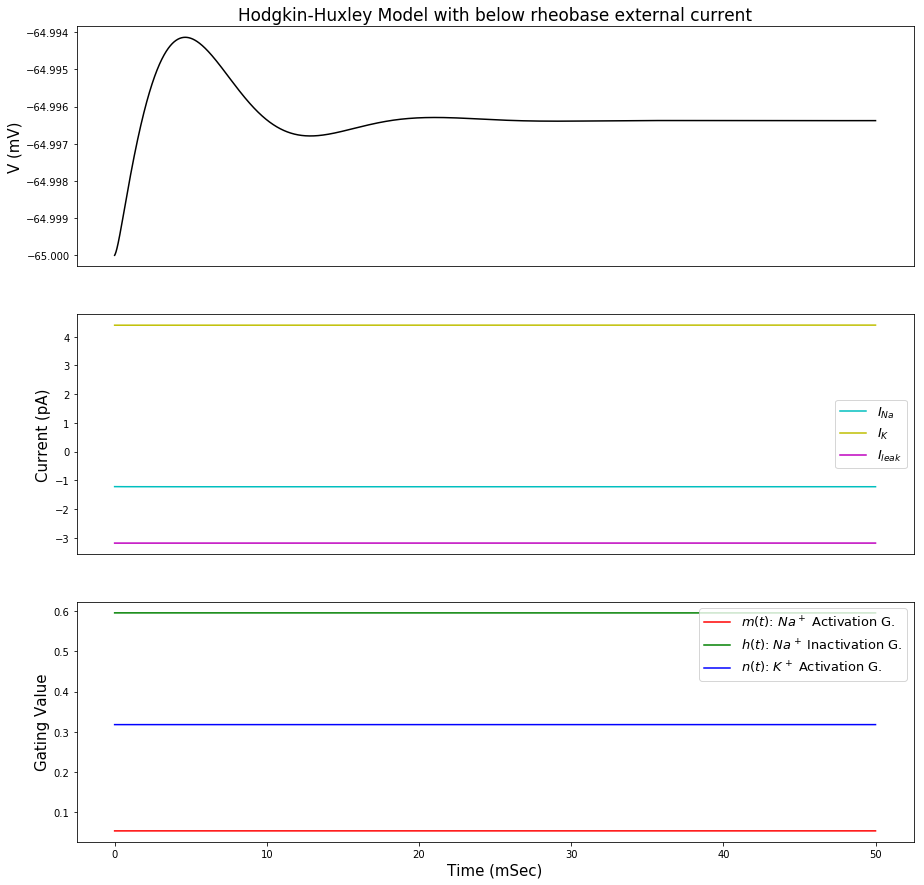

In [5]:
hh_temp = huxley_hodgkin(dt=0.01, max_T=50)
time, V_t, n_t, m_t, h_t, I_Na, I_K, I_leak = hh_temp.run_euler()
plot_results(time, V_t, n_t, m_t, h_t, I_Na, I_K, I_leak,
             title="Hodgkin-Huxley Model with below rheobase external current")

# b - Constant Current

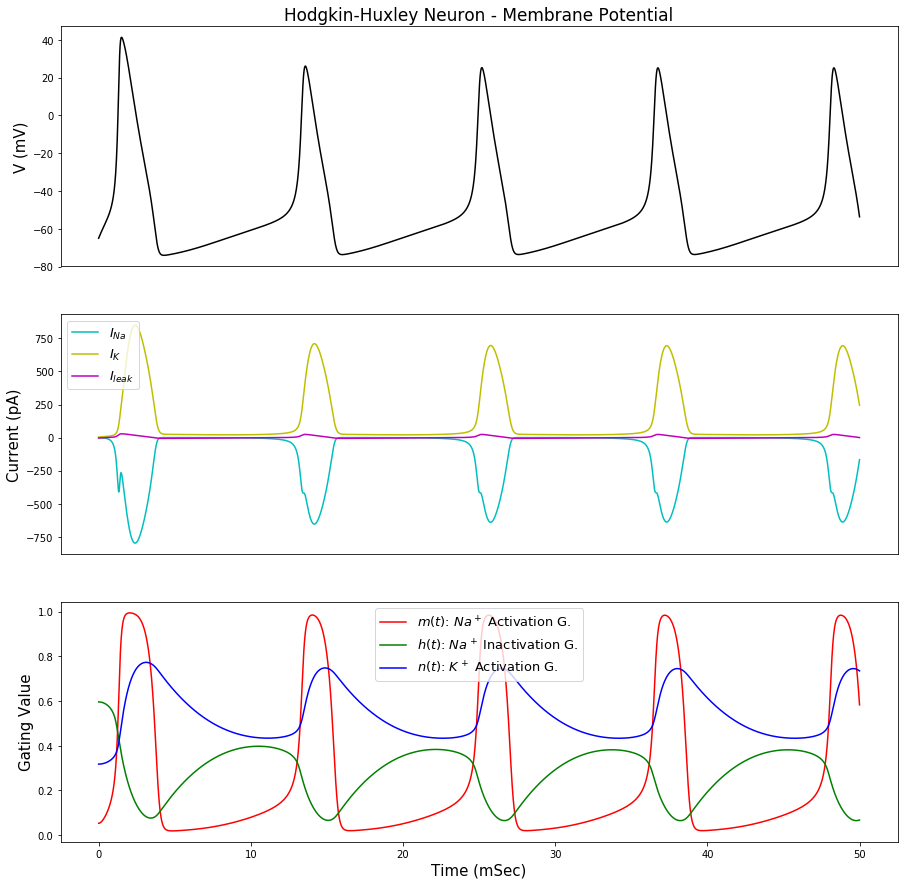

In [6]:
hh_temp = huxley_hodgkin(dt=0.01, max_T=50, I_const=20)
time, V_t, n_t, m_t, h_t, I_Na, I_K, I_leak = hh_temp.run_euler()
plot_results(time, V_t, n_t, m_t, h_t, I_Na, I_K, I_leak)

Interpretation:
* The simulated neuron starts at resting potential. As the external current (above rheobase - more than cancellation of leakage) is applied over time the membrane potential increases and subsequently the transient Sodium channels open due to the high rate of the activation gate ($m\uparrow, h\downarrow$). It comes to a rapid depolarization of the membrane due to the Na+ influx ($-I_{Na} > 0$).

* As Na+ approaches its equilibrium/reversal potential an action potential/spike is elicited. The activation gate closes ($m\downarrow$) and the inactivation gate opens ($h\uparrow$). The Na+ channel becomes inactive ($-I_{Na} \downarrow$).

* Already before that and with a small lag (compared to the Sodium channels) the persistent Potassium channels open ($I_{K} \uparrow$) due to the impact of the activation gate ($n \uparrow$). As they open and K+ effluxes, it comes to a slower repolarization which decreases the membrane potential.

* Ultimately, it comes to an overshoot ($V < E_{mem} = -65$). K+ keeps exiting the cell, trying to reach its equilibrium. Since the channel is persistent and stays open longer this ultimately leads to a hyperpolarization. Only finally the $n$-activation gate closes and the resting potential is reached (due to the now positive effects of the leakage current).

* Since we apply the constant external current over the full time span the action potential mechanism outlined above starts again in circular fashion.

# c - Mean Firing Rate across range of external currents

In [7]:
ext_current_range = np.arange(1, 20, 0.5)
firing_rates = calculate_rheobase(ext_current_range)

External Current: 1.0 - Mean firing rate: 0
External Current: 1.5 - Mean firing rate: 0
External Current: 2.0 - Mean firing rate: 0
External Current: 2.5 - Mean firing rate: 0.010000500025
External Current: 3.0 - Mean firing rate: 0.010000500025
External Current: 3.5 - Mean firing rate: 0.010000500025
External Current: 4.0 - Mean firing rate: 0.010000500025
External Current: 4.5 - Mean firing rate: 0.010000500025
External Current: 5.0 - Mean firing rate: 0.010000500025
External Current: 5.5 - Mean firing rate: 0.010000500025
External Current: 6.0 - Mean firing rate: 0.0150007500375
External Current: 6.5 - Mean firing rate: 0.06000300015
External Current: 7.0 - Mean firing rate: 0.0650032501625
External Current: 7.5 - Mean firing rate: 0.0650032501625
External Current: 8.0 - Mean firing rate: 0.070003500175
External Current: 8.5 - Mean firing rate: 0.070003500175
External Current: 9.0 - Mean firing rate: 0.070003500175
External Current: 9.5 - Mean firing rate: 0.0750037501875
External C

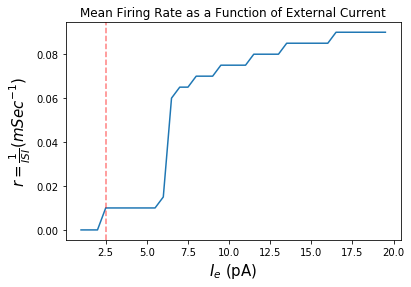

In [8]:
plot_rheobase(ext_current_range, firing_rates)

* The approximate rheobase is 2-2.5 pA which is higher than the rheobase in the  Integrate-and-fire neuron model (ca. 1 pA). This might be due to the specific parameters (e.g. leakage conductance) chosen in our model.

* In general the firing rate curve follows the same discontinuos logarithmic shape as in the IaF neuron case. Although it is not as smooth in the region fro  2.5 to 7.5 pA. This might be due to the chosen resolution (current as well as Euler time steps).

# d - Temporary constant current

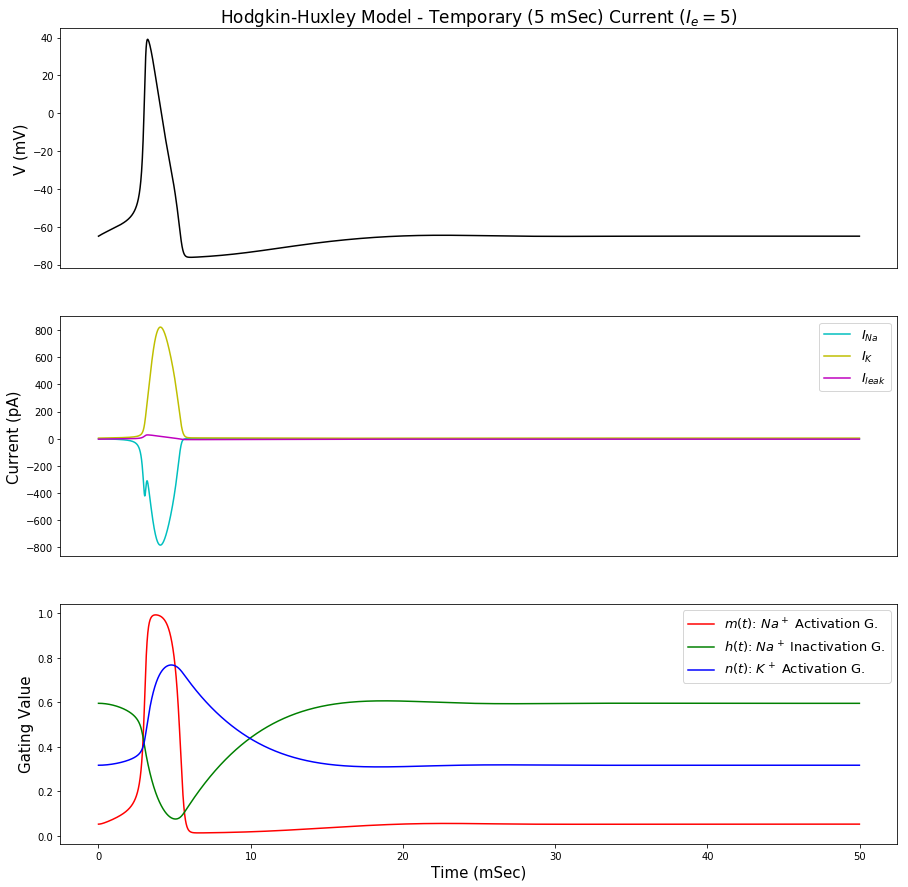

In [9]:
hh_temp = huxley_hodgkin(dt=0.01, max_T=50, I_const=5,
                         ext_current_type="temp_pulse")
time, V_t, n_t, m_t, h_t, I_Na, I_K, I_leak = hh_temp.run_euler()
plot_results(time, V_t, n_t, m_t, h_t, I_Na, I_K, I_leak,
             r"Hodgkin-Huxley Model - Temporary (5 mSec) Current ($I_e = 5$)")

* In this case we apply an above rheobase current for a very short time span (5 mSec) before not applying any additional currnet. In this course a single action potential spike is elicited in the fashion described above.

* Since we don't apply the current over the whole timeframe the variables revert back to their baseline steady states.

# (Bonus) e - Sinusoidal current

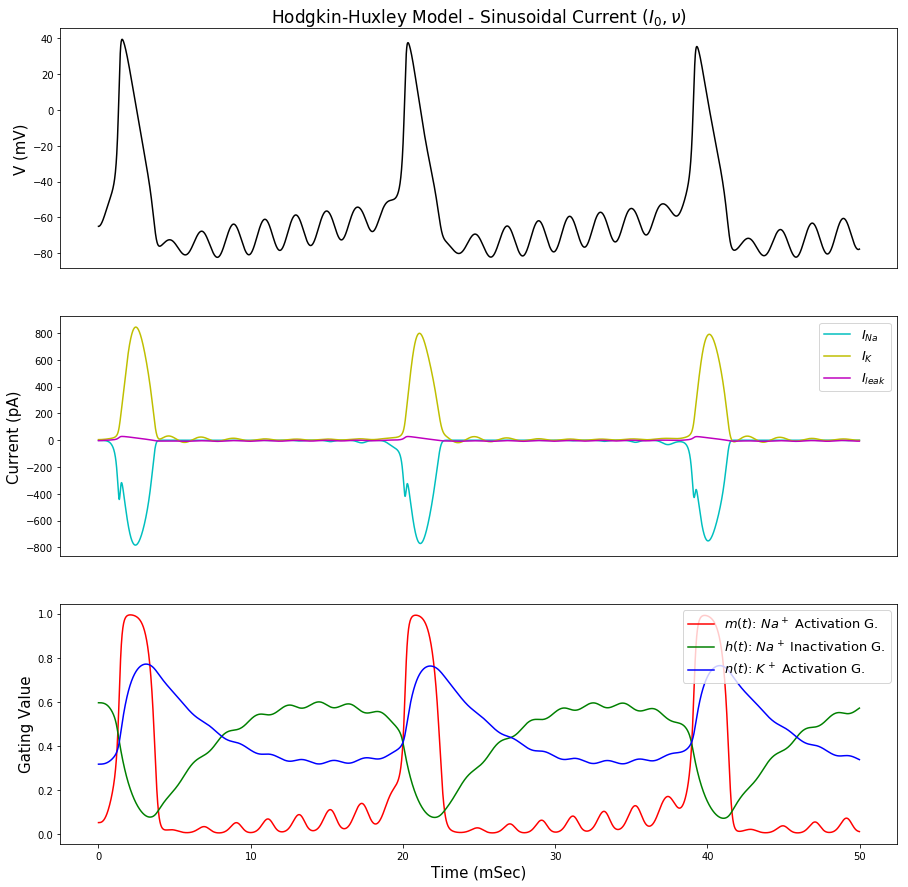

In [10]:
hh_temp = huxley_hodgkin(dt=0.01, max_T=50, I_const=30,
                         ext_current_type="sinusoidal", nu=0.5)
time, V_t, n_t, m_t, h_t, I_Na, I_K, I_leak = hh_temp.run_euler()
plot_results(time, V_t, n_t, m_t, h_t, I_Na, I_K, I_leak,
             r"Hodgkin-Huxley Model - Sinusoidal Current ($I_0, \nu$)")

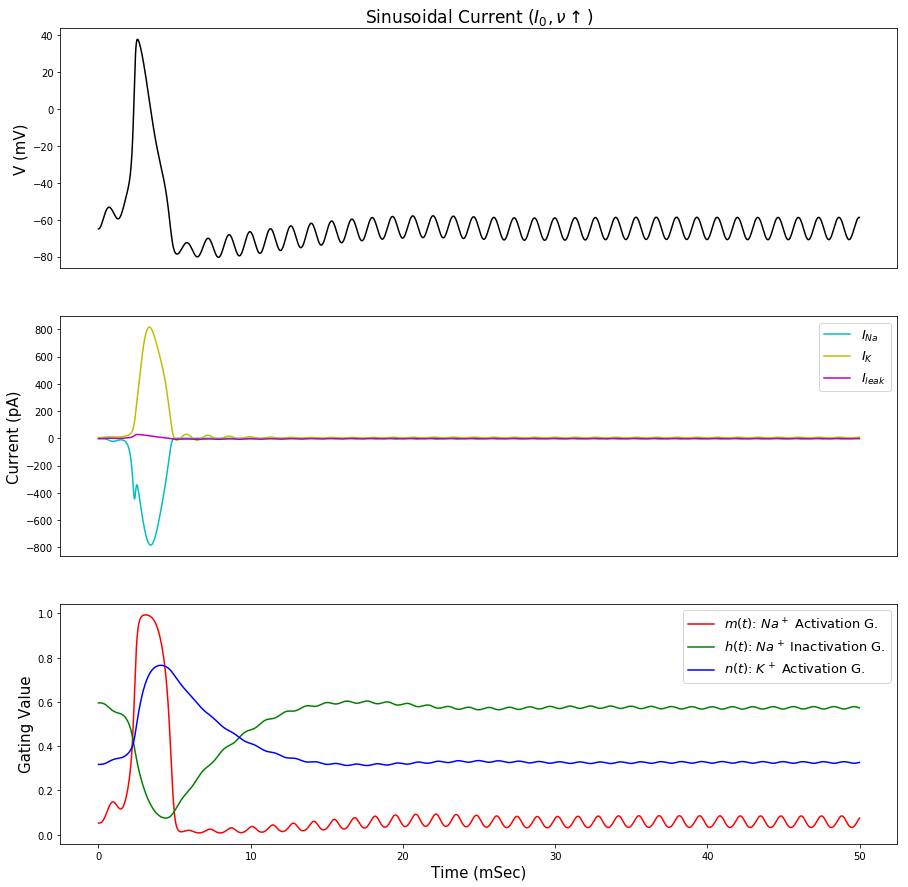

In [11]:
hh_temp = huxley_hodgkin(dt=0.01, max_T=50, I_const=30,
                         ext_current_type="sinusoidal", nu=0.75)
time, V_t, n_t, m_t, h_t, I_Na, I_K, I_leak = hh_temp.run_euler()
plot_results(time, V_t, n_t, m_t, h_t, I_Na, I_K, I_leak,
             r"Sinusoidal Current ($I_0, \nu \uparrow$)")

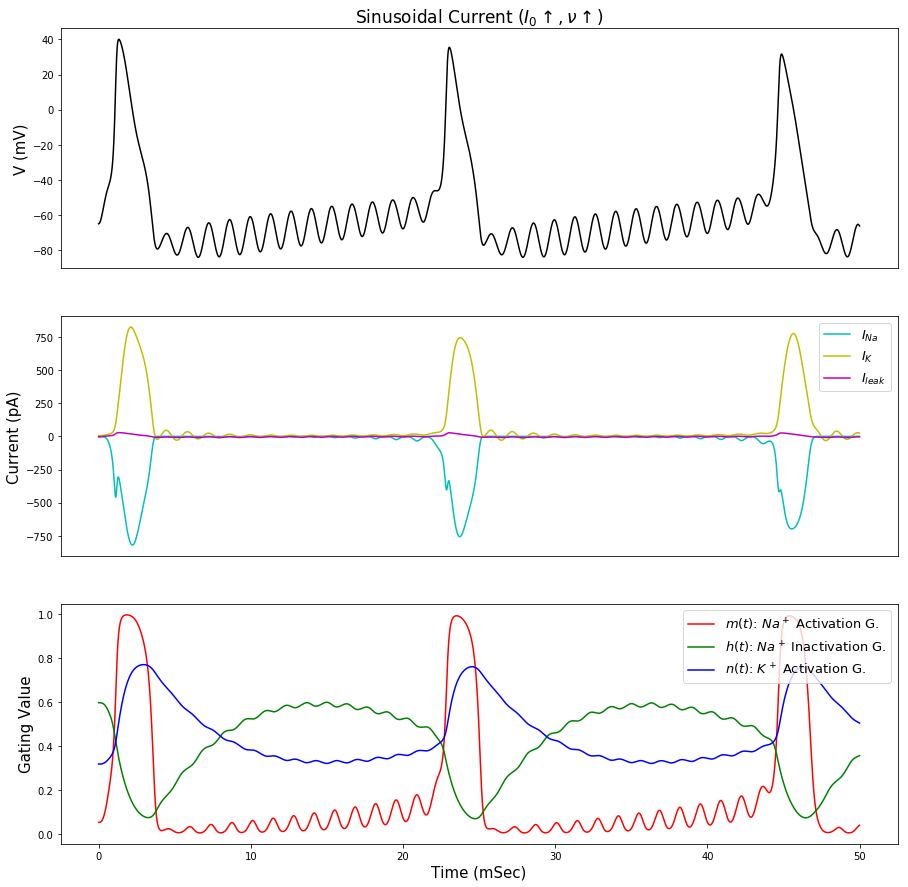

In [12]:
hh_temp = huxley_hodgkin(dt=0.01, max_T=50, I_const=50,
                         ext_current_type="sinusoidal", nu=0.75)
time, V_t, n_t, m_t, h_t, I_Na, I_K, I_leak = hh_temp.run_euler()
plot_results(time, V_t, n_t, m_t, h_t, I_Na, I_K, I_leak,
             r"Sinusoidal Current ($I_0 \uparrow, \nu \uparrow$)")

Note sure how to perform proper conversion. Please help in feedback!

* Membrane potential builds up in harmonic sinusoidal fashion and gating kinematics behavior accordingly. Frequency has an indirect effect which interacts with the leakage. If the frequency is to high the membrane build-up is circumvented. This again can be compensated by increases the baseline current!